In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

In [39]:
# Tải dữ liệu cổ phiếu
stock = "TSLA"
start = "2015-12-01"
end = "2025-3-11"
df = yf.download(stock, start=start, end=end)

df.dropna(inplace=True)  # Xóa giá trị NaN

[*********************100%***********************]  1 of 1 completed


In [40]:
# Tiền xử lý dữ liệu
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(df[['Close']])

# Tạo tập dữ liệu cho mô hình
time_step = 60
X, y = [], []
for i in range(time_step, len(data_scaled)):
    X.append(data_scaled[i-time_step:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)


In [41]:
# Chia tập train và test
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape dữ liệu cho LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [42]:
# Xây dựng mô hình
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0131
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0020
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0013
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0016
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0012    
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0010    
Epoch 8/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011 
Epoch 9/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0010    
Epoch 10/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011    
Epoch 11/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0010
Epoch 12/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.5653e-04
Epoch 13/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.6861e-04
Epoch 14/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010    
Epoch 15/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [43]:
# Dự đoán giá
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Đảm bảo số lượng mẫu khớp nhau
actual_prices = df['Close'][train_size + time_step:train_size + time_step + len(predictions)]

# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
print(f'RMSE: {rmse}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step 
RMSE: 14.133536400925603


In [44]:
# **Dự đoán 15 ngày tiếp theo**
future_predictions = []
input_sequence = X_test[-1].reshape(1, X_test.shape[1], 1)  # Lấy dữ liệu cuối cùng làm đầu vào

for _ in range(15):
    next_day_pred = model.predict(input_sequence)
    future_predictions.append(next_day_pred[0][0])
    next_day_scaled = np.append(input_sequence[0][1:], next_day_pred)
    input_sequence = next_day_scaled.reshape(1, X_test.shape[1], 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print("Dự đoán giá 15 ngày tới:", future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Dự đoán giá 15 ngày tới: [265.90173 263.96704 262.9939  262.6005  262.58047 262.8093  263.20343
 263.70233 264.2602  264.84222 265.42206 265.98068 266.505   266.98685
 267.42218]


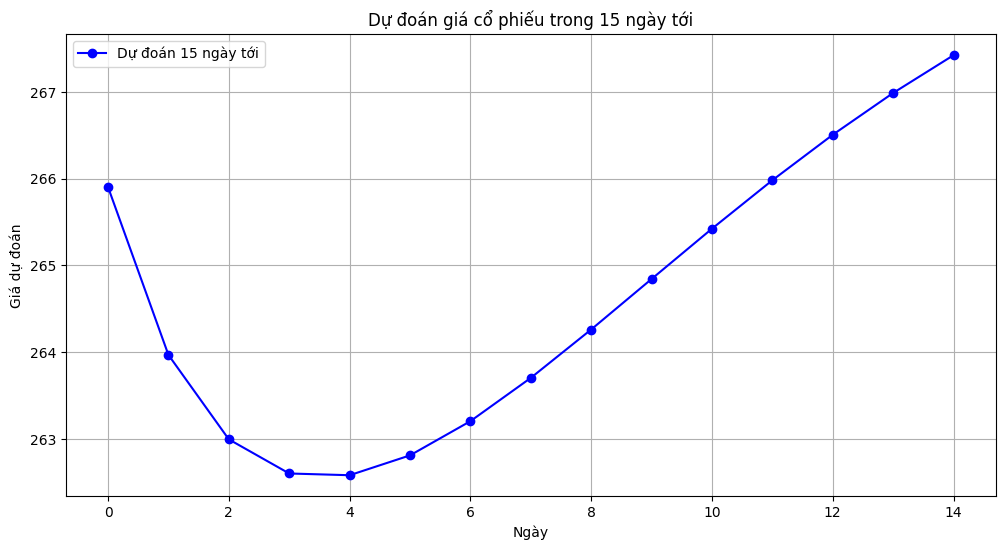

In [48]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(12,6))
plt.plot(range(len(future_predictions)), future_predictions, marker='o', linestyle='-', color='b', label='Dự đoán 15 ngày tới')
plt.xlabel('Ngày')
plt.ylabel('Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu trong 15 ngày tới')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
model.save('stock_model_tuong_lai.keras')